In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplitlib inline

UsageError: Line magic function `%matplitlib` not found.


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3


def build_dataset(words: list[str]):
    X, Y = [], []

    for word in words:
        context = [0] * block_size

        for char in word + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(
    (vocab_size, n_embd), generator=g
)  # Embedding layer: (vocab_size, n_embd) -> vocab_size * n_embd
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
)  # (size, n_embd * block_size) @ -> _(n_embd * block_size, n_hidden)_ <-
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [12]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view((emb.shape[0], -1))  # concateneate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3069
  10000/ 200000: 2.1900
  20000/ 200000: 2.2707
  30000/ 200000: 2.4296
  40000/ 200000: 1.9041
  50000/ 200000: 2.3865
  60000/ 200000: 2.3392
  70000/ 200000: 2.0873
  80000/ 200000: 2.2595
  90000/ 200000: 2.1146
 100000/ 200000: 1.8817
 110000/ 200000: 2.1622
 120000/ 200000: 1.8919
 130000/ 200000: 2.3128
 140000/ 200000: 2.3481
 150000/ 200000: 2.1759
 160000/ 200000: 1.8034
 170000/ 200000: 1.7760
 180000/ 200000: 1.8991
 190000/ 200000: 1.8666


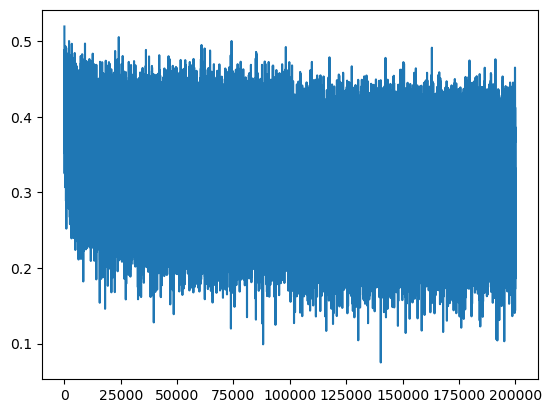

In [13]:
plt.plot(lossi)


In [14]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    embcat = emb.view((x.shape[0], -1))
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.05790114402771
val 2.113706350326538


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if not ix:
            break
    print("".join(itos[i] for i in out))


carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.
